In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from llama_cpp import Llama
from scipy.special import softmax
from scipy.spatial.distance import cosine

def generate_with_logits(llm, prompt, max_tokens=128, temperature=0.7):
    """
    Generate text and derive approximate token entropy from token_logprobs.
    Works for OpenAI-compatible llama_cpp API responses.
    """
    output = llm(
        prompt,
        max_tokens=max_tokens,
        temperature=temperature,
        logprobs=1,        # request logprobs explicitly
        stop=["\n\n"]
    )

    choice = output["choices"][0]
    text = choice["text"]
    lp_data = choice.get("logprobs", {})

    token_logprobs = lp_data.get("token_logprobs", [])
    if not token_logprobs:
        raise ValueError("No token_logprobs found. Ensure logprobs=1 in call.")

    # Convert to probabilities
    probs = np.exp(np.clip(token_logprobs, -20, 0))  # avoid underflow
    # Entropy proxy: -Σ p log p per token sequence
    entropy = -np.sum(probs * np.log(probs + 1e-12))
    mean_entropy = entropy / len(probs)

    return text, mean_entropy, probs

def mean_token_entropy(logits):
    """Compute mean entropy across generated tokens."""
    probs = softmax(logits, axis=-1)
    ent = -np.sum(probs * np.log(probs + 1e-12), axis=-1)
    return float(np.mean(ent))

from scipy.spatial.distance import jensenshannon

def retrieval_sensitivity(llm, query, context_full, context_null, max_tokens=128):
    """Measure divergence in token-level probabilities (retrieval sensitivity)."""
    prompt_full = f"Context:\n{context_full}\n\nQuestion: {query}\nAnswer:"
    prompt_null = f"Context:\n{context_null}\n\nQuestion: {query}\nAnswer:"

    _, H_full, p_full = generate_with_logits(llm, prompt_full, max_tokens)
    _, H_null, p_null = generate_with_logits(llm, prompt_null, max_tokens)

    n = min(len(p_full), len(p_null))
    p_full, p_null = np.array(p_full[:n]), np.array(p_null[:n])

    # Jensen–Shannon divergence for smoother comparison
    sens = jensenshannon(p_full, p_null)
    return {"retrieval_JS": float(sens), "entropy_full": H_full, "entropy_null": H_null}

In [21]:
from pathlib import Path

MODEL_PATH = Path.home() / "Documents/research/models/qwen2.5-7b-instruct-q4_k_m-00001-of-00002.gguf"

llm = Llama(
    model_path=str(MODEL_PATH),
    n_ctx=4096,
    n_threads=6,
    n_batch=256,
    use_mlock=True,
    logits_all=True,
    verbose=False
)

print("✅ Model loaded.")

llama_context: n_ctx_per_seq (4096) < n_ctx_train (131072) -- the full capacity of the model will not be utilized
ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64

✅ Model loaded.


In [22]:
queries = [
    "Recent privilege escalation vulnerabilities in Linux kernels",
    "Buffer overflow vulnerabilities in Linux drivers",
    "Use-after-free issues in kernel modules"
]

contexts_full = [
    "The vulnerability in the Linux kernel's io_uring subsystem allows local users to gain privileges.",
    "Several buffer overflow issues in kernel networking code were patched in Linux 6.2.",
    "Use-after-free bugs in the ext4 filesystem may lead to kernel crashes or code execution."
]
contexts_null = [" "] * len(queries)  # empty context baseline

In [23]:
from tqdm import tqdm

records = []

for q, cf, cn in tqdm(zip(queries, contexts_full, contexts_null), total=len(queries)):
    # Run generation once with context to get entropy
    prompt = f"Context:\n{cf}\n\nQuestion: {q}\nAnswer:"
    text, H_mean, _ = generate_with_logits(llm, prompt)

    # Compute retrieval sensitivity using JS divergence (with vs. without context)
    sens = retrieval_sensitivity(llm, q, cf, cn)

    records.append({
        "query": q,
        "entropy_full": H_mean,
        **sens
    })

df_uncert = pd.DataFrame(records)
df_uncert

100%|███████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:12<00:00, 24.20s/it]


,query,entropy_full,retrieval_JS,entropy_null
0,Recent privilege escalation vulnerabilities in...,0.139127,0.199295,0.199859
1,Buffer overflow vulnerabilities in Linux drivers,0.194573,0.220653,0.185101
2,Use-after-free issues in kernel modules,0.175539,0.211023,0.186447


/var/folders/n0/l2z_5jzs5_ld852y4kztbyz40000gq/T/ipykernel_96849/3555270667.py:30: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


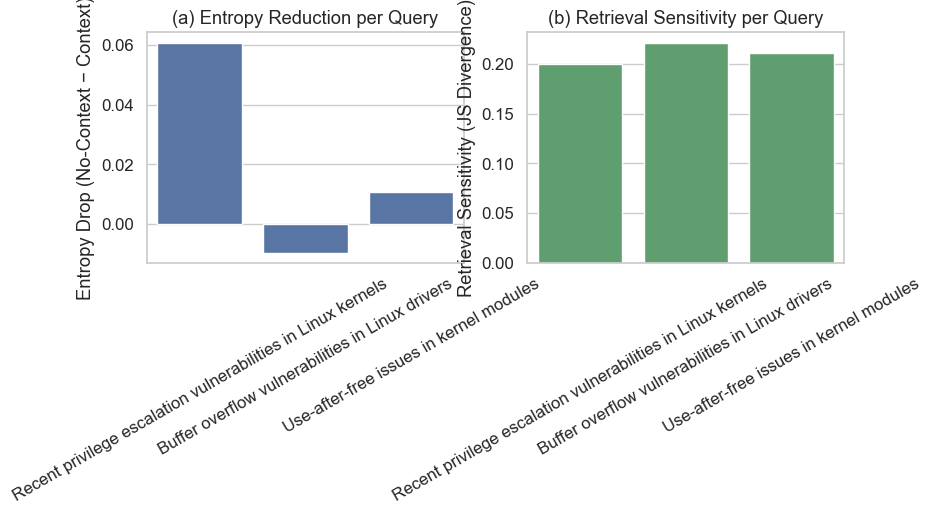

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3))
sns.set(style="whitegrid", font_scale=1.1)

# (a) Entropy drop
sns.barplot(
    x="query",
    y="entropy_drop",
    data=df_uncert,
    color="#4C72B0",
    ax=axes[0]
)
axes[0].set_ylabel("Entropy Drop (No-Context − Context)")
axes[0].set_xlabel("")
axes[0].set_title("(a) Entropy Reduction per Query")
axes[0].tick_params(axis='x', rotation=30)

# (b) Retrieval sensitivity
sns.barplot(
    x="query",
    y="retrieval_JS",
    data=df_uncert,
    color="#55A868",
    ax=axes[1]
)
axes[1].set_ylabel("Retrieval Sensitivity (JS Divergence)")
axes[1].set_xlabel("")
axes[1].set_title("(b) Retrieval Sensitivity per Query")
axes[1].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.savefig("fig6_internal_uncertainty_clean.png", dpi=300, bbox_inches="tight")
plt.show()